# Feature Exploration: Why Do Features Fail?

## Goal
Understand why feature representations fail to correctly group similar images.

## Analysis Flow
1. **Load Features** - Get cached features from experiment
2. **Select Groups** - Choose specific groups to analyze
3. **Discriminability Analysis** - Which features separate groups well vs poorly?
4. **2D Visualization** - PCA projection to see group separation
5. **Feature Attribution** - Grad-CAM (ResNet-50 only)

## Key Metric: Feature Discriminability
**Fisher Criterion = Between-Group Variance / Within-Group Variance**
- High score = Groups well-separated, tight within-group ׳³ג€™׳’ג‚¬ֲ ׳’ג‚¬ג„¢ Good feature
- Low score = Groups overlap, loose within-group ׳³ג€™׳’ג‚¬ֲ ׳’ג‚¬ג„¢ Bad feature

In [ ]:
import warnings
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sim_bench.analysis.utils import get_project_root
import sim_bench.analysis.feature_utils as feature_utils
import sim_bench.analysis.feature_viz as feature_viz
from sim_bench.analysis.export import save_figure, export_notebook_to_pdf, archive_notebook

warnings.filterwarnings('ignore')
%matplotlib inline

## 1. Configuration

In [ ]:
PROJECT_ROOT = get_project_root()
FEATURE_CACHE_DIR = PROJECT_ROOT / "artifacts" / "feature_cache"

# === EXPERIMENT ===
EXPERIMENT_DIR = PROJECT_ROOT / "outputs" / "baseline_runs" / "comprehensive_baseline" / "2025-10-08_16-25-49"
METHOD_NAME = "sift_bovw"  # Options: 'deep', 'sift_bovw', 'emd'
DATASET_TYPE = "ukbench"

# === QUERY SELECTION ===
QUERY_INDICES = list(range(7144, 7152))  # Analyze 2 groups

# === OUTPUT OPTIONS ===
SAVE_PLOTS = True  # Save plots to disk for README integration
EXPORT_PDF = True  # Export entire notebook to PDF

print(f"Method: {METHOD_NAME}")
print(f"Analyzing {len(QUERY_INDICES)} queries")
print(f"Save plots: {SAVE_PLOTS}")
print(f"Export PDF: {EXPORT_PDF}")

Method: sift_bovw
Analyzing 8 queries


## 2. Load Features

In [3]:
cache_file = feature_utils.find_cache_for_method(METHOD_NAME, FEATURE_CACHE_DIR)
if cache_file is None:
    raise FileNotFoundError(f"No cache for '{METHOD_NAME}'")

features, metadata = feature_utils.load_features_from_cache(cache_file, return_metadata=True)
image_paths = metadata['image_paths']

# Extract query features and groups
query_features = feature_utils.get_features_by_index(QUERY_INDICES, cache_file)
query_paths = [image_paths[idx] for idx in QUERY_INDICES]
query_group_ids = feature_utils.extract_group_labels_from_paths(query_paths, dataset_type=DATASET_TYPE)

print(f"Loaded {len(features)} feature vectors (dim={features.shape[1]})")
print(f"Query groups: {sorted(set(query_group_ids))}")

Loaded 10200 feature vectors (dim=512)
Query groups: [1786, 1787]


## 3. Feature Discriminability Analysis

**Question:** Which features separate groups well vs poorly?

**Metric:** Fisher Criterion = Between-Group Variance / Within-Group Variance
- **High** = Good separation, tight groups
- **Low** = Poor separation, loose groups

In [ ]:
disc_results = feature_utils.analyze_feature_discriminability(
    feature_matrix=query_features,
    group_ids=query_group_ids,
    top_k=20
)

print("Top 10 Most Discriminative Features (Good):")
for i in range(10):
    dim = disc_results['top_discriminative_dims'][i]
    score = disc_results['top_discriminative_scores'][i]
    print(f"  Feature {dim:4d}: Fisher = {score:.4f}")

print("\nTop 10 Least Discriminative Features (Bad):")
worst_indices = np.argsort(disc_results['fisher_scores'])[:10]
for dim in worst_indices:
    score = disc_results['fisher_scores'][dim]
    print(f"  Feature {dim:4d}: Fisher = {score:.4f}")

Top 10 Most Discriminative Features (Good):
  Feature  307: Fisher = 12.4094
  Feature   19: Fisher = 9.6849
  Feature  369: Fisher = 9.2991
  Feature  374: Fisher = 7.6368
  Feature   36: Fisher = 7.1389
  Feature   21: Fisher = 5.4802
  Feature  111: Fisher = 5.4509
  Feature  441: Fisher = 5.1357
  Feature  231: Fisher = 5.0989
  Feature  240: Fisher = 4.7884

Top 10 Least Discriminative Features (Bad):
  Feature  188: Fisher = 0.0000
  Feature  118: Fisher = 0.0000
  Feature  301: Fisher = 0.0000
  Feature  404: Fisher = 0.0000
  Feature  406: Fisher = 0.0000
  Feature  122: Fisher = 0.0000
  Feature  123: Fisher = 0.0000
  Feature  295: Fisher = 0.0000
  Feature  117: Fisher = 0.0000
  Feature  125: Fisher = 0.0000


### Visualize Best vs Worst Features

**Box plots show:**
- X-axis = Group ID
- Y-axis = Feature value
- Box = Spread within group
- Dots = Individual queries

In [5]:
disc_results = feature_utils.analyze_feature_discriminability(
    feature_matrix=query_features,
    group_ids=query_group_ids,
    top_k=20
)

print("Top 10 Most Discriminative Features (Good):")
for i in range(10):
    dim = disc_results["top_discriminative_dims"][i]
    score = disc_results["top_discriminative_scores"][i]
    print(f"  Feature {dim:4d}: Fisher = {score:.4f}")

print("\nTop 10 Least Discriminative Features (Bad):")
worst_indices = np.argsort(disc_results["fisher_scores"])[:10]
for dim in worst_indices:
    score = disc_results["fisher_scores"][dim]
    print(f"  Feature {dim:4d}: Fisher = {score:.4f}")

Top 10 Most Discriminative Features (Good):
  Feature  307: Fisher = 12.4094
  Feature   19: Fisher = 9.6849
  Feature  369: Fisher = 9.2991
  Feature  374: Fisher = 7.6368
  Feature   36: Fisher = 7.1389
  Feature   21: Fisher = 5.4802
  Feature  111: Fisher = 5.4509
  Feature  441: Fisher = 5.1357
  Feature  231: Fisher = 5.0989
  Feature  240: Fisher = 4.7884

Top 10 Least Discriminative Features (Bad):
  Feature  188: Fisher = 0.0000
  Feature  118: Fisher = 0.0000
  Feature  301: Fisher = 0.0000
  Feature  404: Fisher = 0.0000
  Feature  406: Fisher = 0.0000
  Feature  122: Fisher = 0.0000
  Feature  123: Fisher = 0.0000
  Feature  295: Fisher = 0.0000
  Feature  117: Fisher = 0.0000
  Feature  125: Fisher = 0.0000


## 3.5 Within-Group Feature Variance Analysis

**Question:** Which features vary the most WITHIN each group?

**Why Important:** 
- High within-group variance = feature is inconsistent for similar images
- These features may cause retrieval failures
- We can visualize them with box plots and Grad-CAM

**Method:**
1. Find top-5 features with highest variance within each group
2. Box plot: X-axis = group, colored by query index
3. Grad-CAM: Visualize which pixels activate these features


In [ ]:
# Compute within-group variance for each group
diversity_results = feature_utils.analyze_within_group_feature_diversity(
    query_indices=QUERY_INDICES,
    query_group_ids=query_group_ids,
    cache_file=cache_file,
    top_k=5,  # Top 5 most variable features per group
    metrics=['variance']
)

# Display results
for gid, result in sorted(diversity_results.items()):
    print(f"\n{'='*60}")
    print(f"Group {gid}: {result['n_images']} images")
    print(f"Query indices: {result['query_indices_in_group']}")
    print(f"Mean variance across all features: {result['mean_variance']:.6f}")
    print(f"\nTop 5 Features with Highest Within-Group Variance:")
    
    top_dims = result['top_diverse_dims_by_metric']['variance']
    top_vars = result['top_diverse_values_by_metric']['variance']
    
    for rank, (dim, var) in enumerate(zip(top_dims, top_vars), 1):
        print(f"  {rank}. Feature {dim:4d}: Variance = {var:.6f}")



Group 1786: 4 images
Query indices: [7144, 7145, 7146, 7147]
Mean variance across all features: 0.000352

Top 5 Features with Highest Within-Group Variance:
  1. Feature  176: Variance = 0.006395
  2. Feature   98: Variance = 0.006057
  3. Feature   46: Variance = 0.005759
  4. Feature    0: Variance = 0.005382
  5. Feature  134: Variance = 0.005021

Group 1787: 4 images
Query indices: [7148, 7149, 7150, 7151]
Mean variance across all features: 0.000557

Top 5 Features with Highest Within-Group Variance:
  1. Feature  506: Variance = 0.030607
  2. Feature  251: Variance = 0.022553
  3. Feature   98: Variance = 0.016548
  4. Feature    0: Variance = 0.013797
  5. Feature  450: Variance = 0.010587


### Box Plots: High-Variance Features by Group

Visualize the top-5 high-variance features for each group.
- X-axis: Group ID
- Y-axis: Feature value
- Each query is a separate point, colored by query index


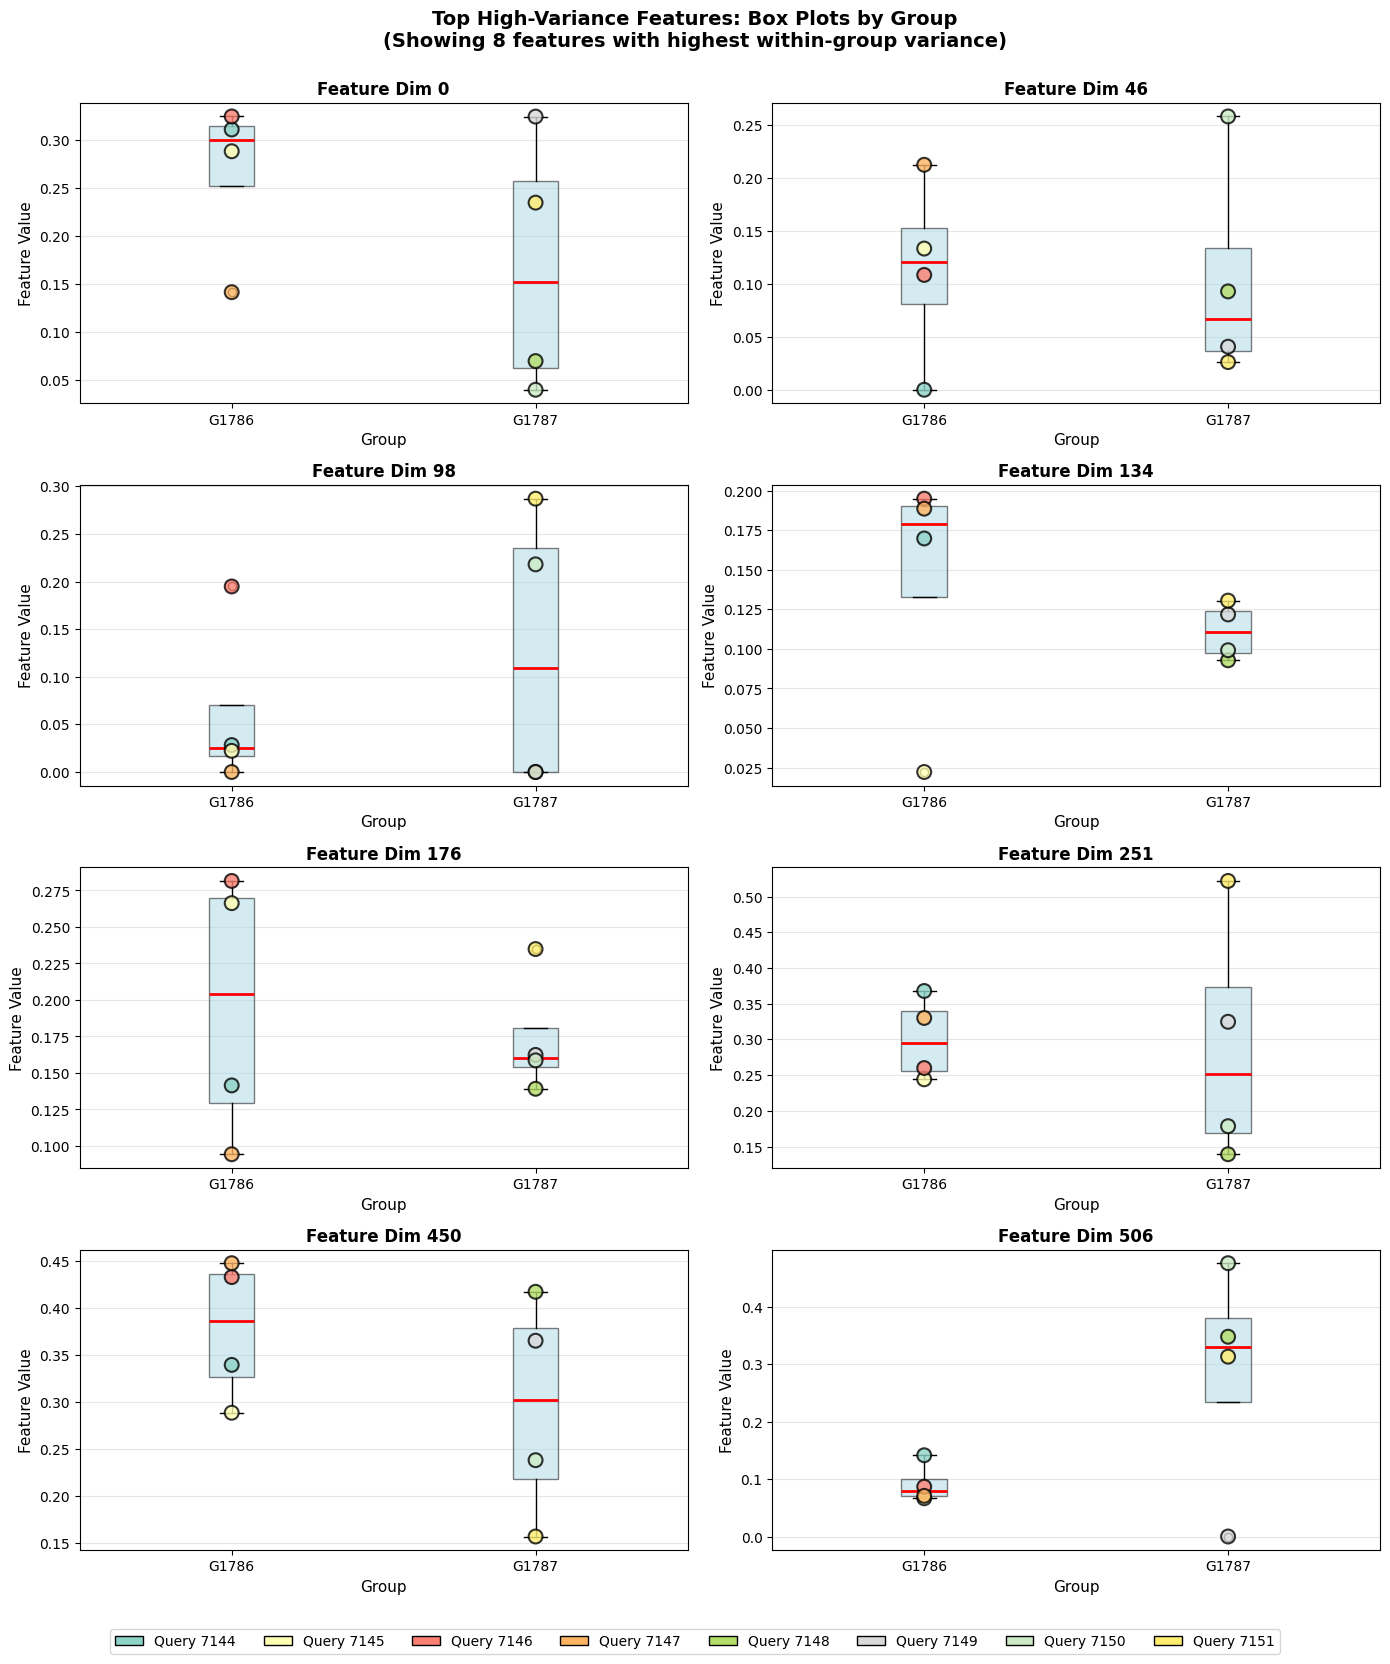

In [ ]:
# Collect all high-variance features across groups
all_high_var_features = set()
for gid, result in diversity_results.items():
    top_dims = result['top_diverse_dims_by_metric']['variance']
    all_high_var_features.update(top_dims)

# Create box plots for each high-variance feature
n_features_to_plot = min(10, len(all_high_var_features))
features_to_plot = sorted(list(all_high_var_features))[:n_features_to_plot]

# Setup color map for queries
unique_queries = sorted(set(QUERY_INDICES))
query_colors = plt.cm.Set3(np.linspace(0, 1, len(unique_queries)))
query_to_color = dict(zip(unique_queries, query_colors))

# Create figure
n_cols = 2
n_rows = (n_features_to_plot + 1) // 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

for idx, feature_dim in enumerate(features_to_plot):
    ax = axes[idx]
    
    # Prepare data for box plot
    box_data = []
    box_labels = []
    scatter_x = []
    scatter_y = []
    scatter_colors = []
    
    for gid in sorted(diversity_results.keys()):
        result = diversity_results[gid]
        query_indices_in_group = result['query_indices_in_group']
        
        # Get feature values for this dimension
        feature_values = query_features[
            [QUERY_INDICES.index(qidx) for qidx in query_indices_in_group], 
            feature_dim
        ]
        
        box_data.append(feature_values)
        box_labels.append(f'G{gid}')
        
        # Add scatter points colored by query
        for i, (qidx, val) in enumerate(zip(query_indices_in_group, feature_values)):
            scatter_x.append(len(box_data))
            scatter_y.append(val)
            scatter_colors.append(query_to_color[qidx])
    
    # Create box plot
    bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True,
                     boxprops=dict(facecolor='lightblue', alpha=0.5),
                     medianprops=dict(color='red', linewidth=2))
    
    # Overlay scatter points
    ax.scatter(scatter_x, scatter_y, c=scatter_colors, s=100, 
              alpha=0.8, edgecolors='black', linewidth=1.5, zorder=10)
    
    ax.set_xlabel('Group', fontsize=11)
    ax.set_ylabel('Feature Value', fontsize=11)
    ax.set_title(f'Feature Dim {feature_dim}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

# Hide unused subplots
for idx in range(n_features_to_plot, len(axes)):
    axes[idx].axis('off')

# Create legend for queries
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=query_to_color[q], label=f'Query {q}', 
                         edgecolor='black') 
                  for q in unique_queries]
fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, -0.02),
          ncol=len(unique_queries), fontsize=10)

plt.suptitle(f'Top High-Variance Features: Box Plots by Group\n' +
            f'(Showing {n_features_to_plot} features with highest within-group variance)',
            fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()

# Save figure to disk
if SAVE_PLOTS:
    output_dir = EXPERIMENT_DIR / "analysis_reports"
    saved_path = save_figure(
        fig=fig,
        output_dir=output_dir,
        filename="high_variance_boxplots",
        notebook_type="feature_exploration",
        method_name=METHOD_NAME
    )
    print(f"✓ Saved plot: {saved_path.relative_to(PROJECT_ROOT)}")

plt.show()


### Feature Attribution: Visualize What Activates High-Variance Features

**Goal:** Visualize which image regions contribute to high-variance features

**Method (Deep/ResNet-50):** 
- Use Grad-CAM to create attribution heatmaps
- Show top-4 high-variance features for each query image
- Overlay heatmaps on original images

**Method (SIFT BoVW):**
- Show keypoints assigned to high-variance visual words
- Red keypoints with orientation arrows
- Each panel shows where a specific visual word appears


Initializing SIFT BoVW attribution extractor...
✓ Ready

Visualizing keypoints for top 4 high-variance visual words:
  1. Visual Word 506: Variance = 0.030607
  2. Visual Word 251: Variance = 0.022553
  3. Visual Word 98: Variance = 0.016548
  4. Visual Word 0: Variance = 0.013797


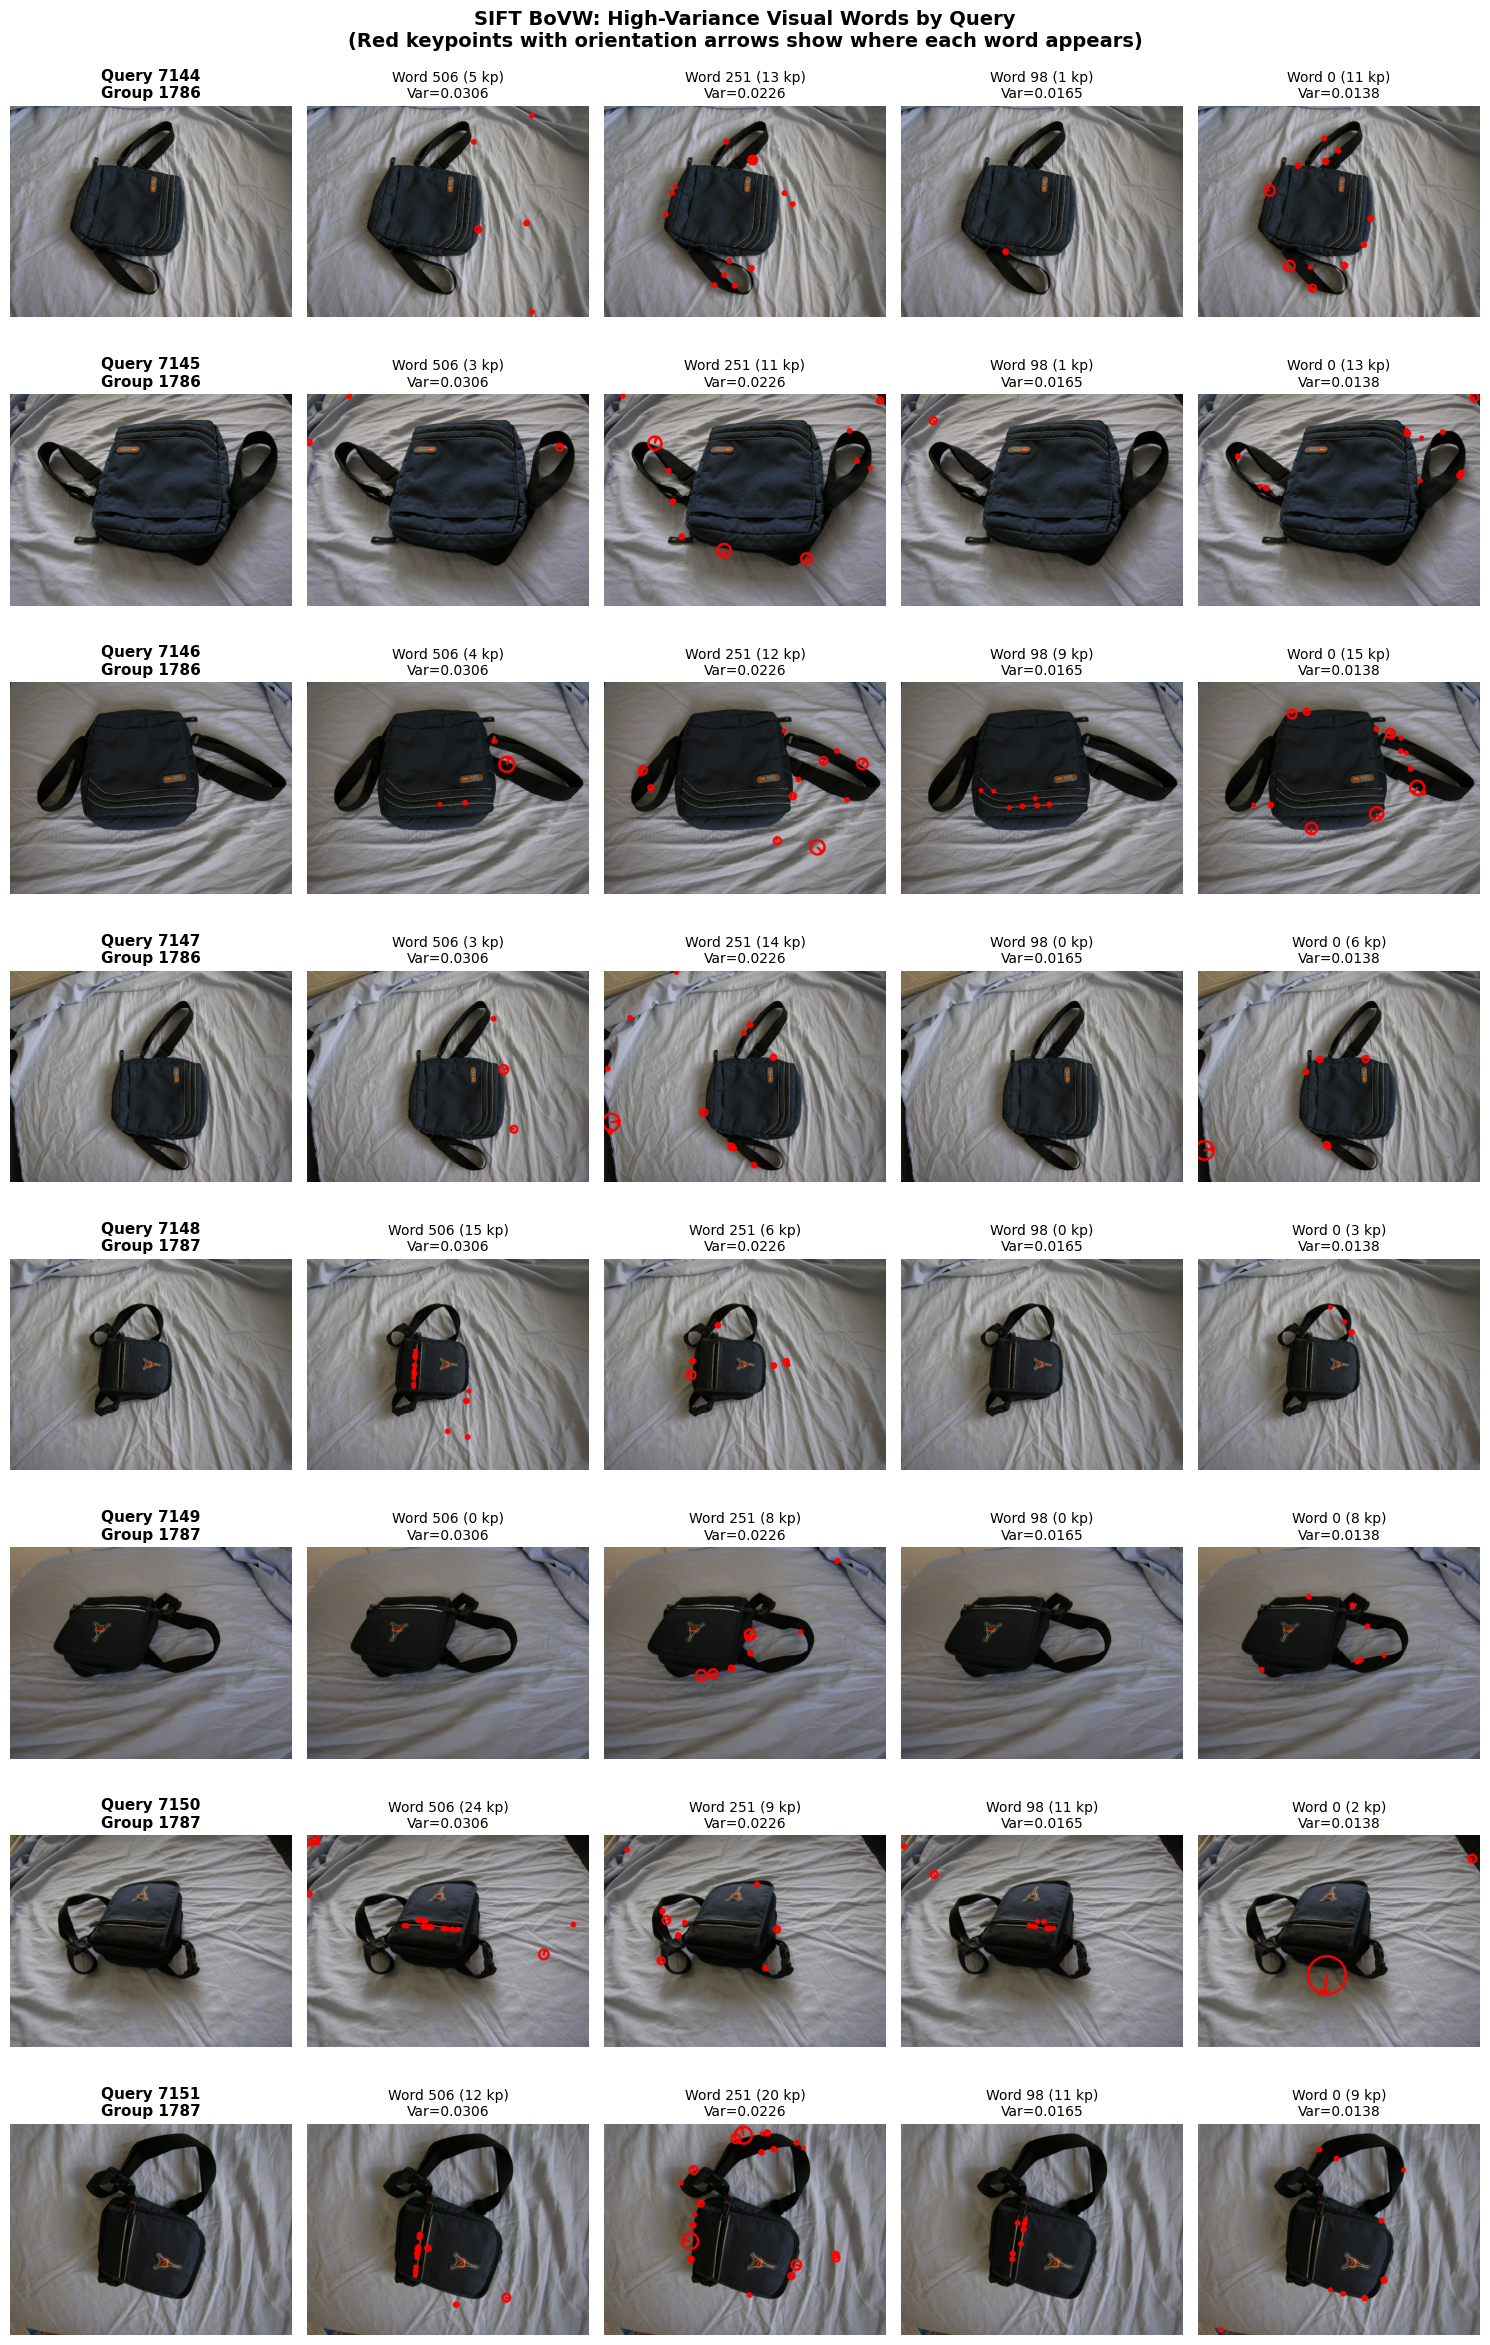

In [ ]:
# Import common visualization module
from sim_bench.analysis.attribution_viz import get_top_variance_features

# Get top-4 high-variance features (works for both methods)
top_features, all_variances = get_top_variance_features(diversity_results, top_k=4)

# Method-specific visualization
attribution_fig = None

if METHOD_NAME == 'deep':
    from sim_bench.analysis.attribution.resnet50 import ResNet50AttributionExtractor
    from sim_bench.analysis.attribution.visualization import plot_attribution_overlay
    from sim_bench.analysis.attribution_viz import visualize_deep_attribution
    
    print("Initializing ResNet-50 attribution extractor...")
    extractor = ResNet50AttributionExtractor(device='cpu')
    print("✓ Ready\n")
    
    attribution_fig = visualize_deep_attribution(
        extractor=extractor,
        query_indices=QUERY_INDICES,
        query_group_ids=query_group_ids,
        image_paths=image_paths,
        top_features=top_features,
        all_variances=all_variances,
        plot_attribution_overlay_func=plot_attribution_overlay
    )

elif METHOD_NAME == 'sift_bovw':
    from sim_bench.analysis.attribution.sift_bovw import SIFTBoVWAttributionExtractor, draw_keypoints_for_word
    from sim_bench.analysis.attribution_viz import visualize_sift_attribution
    
    print("Initializing SIFT BoVW attribution extractor...")
    codebook_path = PROJECT_ROOT / "artifacts" / "sift_bovw" / "codebook.pkl"
    
    if not codebook_path.exists():
        print(f"⚠ Codebook not found: {codebook_path}")
        print("  Run SIFT method first to generate codebook.")
    else:
        extractor = SIFTBoVWAttributionExtractor(str(codebook_path))
        print("✓ Ready\n")
        
        attribution_fig = visualize_sift_attribution(
            extractor=extractor,
            query_indices=QUERY_INDICES,
            query_group_ids=query_group_ids,
            image_paths=image_paths,
            top_features=top_features,
            all_variances=all_variances,
            draw_keypoints_func=draw_keypoints_for_word
        )

else:
    print(f"⚠ Attribution visualization available for 'deep' or 'sift_bovw'")
    print(f"  Current method: {METHOD_NAME}")

# Save figure to disk
if SAVE_PLOTS and attribution_fig is not None:
    output_dir = EXPERIMENT_DIR / "analysis_reports"
    saved_path = save_figure(
        fig=attribution_fig,
        output_dir=output_dir,
        filename="attribution_visualization",
        notebook_type="feature_exploration",
        method_name=METHOD_NAME
    )
    print(f"\n✓ Saved plot: {saved_path.relative_to(PROJECT_ROOT)}")

# Show the figure
if attribution_fig is not None:
    plt.show()


## 4. 2D Visualization

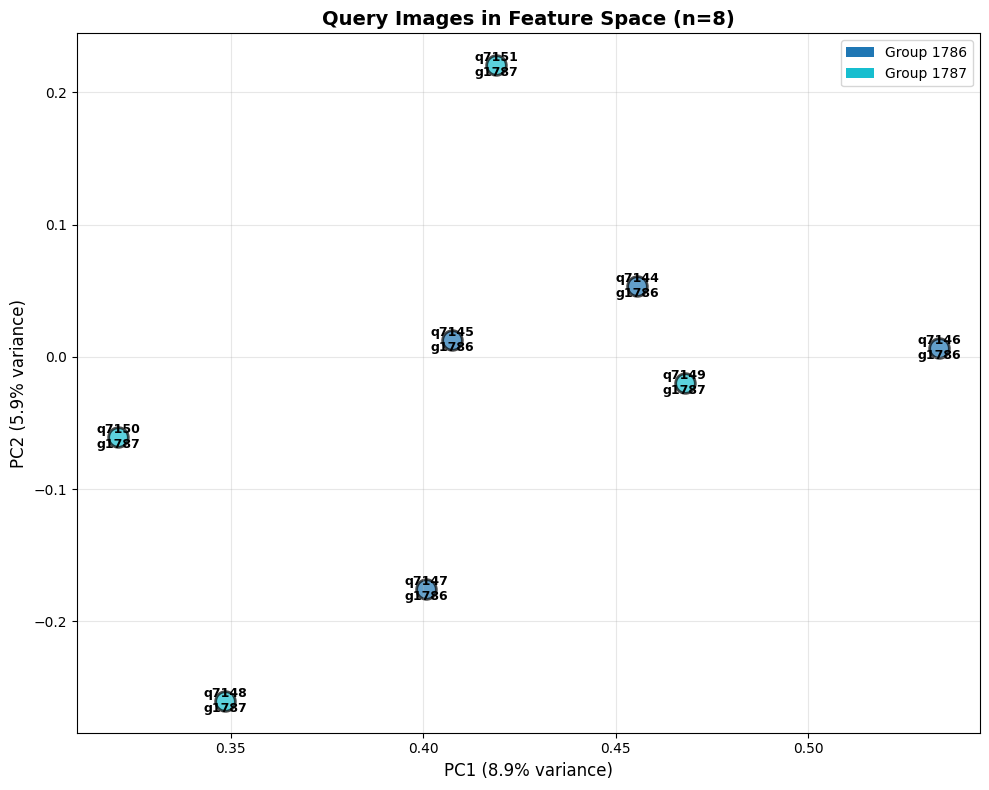

In [ ]:
feature_viz.plot_queries_by_group(
    query_features=query_features,
    query_group_ids=query_group_ids,
    query_indices=QUERY_INDICES,
    all_features=features,
    figsize=(10, 8)
)

# Save figure to disk
if SAVE_PLOTS:
    output_dir = EXPERIMENT_DIR / "analysis_reports"
    saved_path = save_figure(
        fig=plt.gcf(),
        output_dir=output_dir,
        filename="pca_2d_visualization",
        notebook_type="feature_exploration",
        method_name=METHOD_NAME
    )
    print(f"✓ Saved plot: {saved_path.relative_to(PROJECT_ROOT)}")

plt.show()

## 5. Feature Attribution (ResNet-50 Only)

**Goal:** Visualize which image pixels contribute to discriminative features.

**Method:** Grad-CAM on top-4 most discriminative features.

In [ ]:
if METHOD_NAME == 'deep':
    from sim_bench.analysis.attribution.resnet50 import ResNet50AttributionExtractor
    from sim_bench.analysis.attribution.visualization import plot_attribution_overlay
    from PIL import Image
    
    print("Initializing ResNet-50 extractor...")
    extractor = ResNet50AttributionExtractor(device='cpu')
    print("Ready")
else:
    print(f"Grad-CAM only available for 'deep' method (current: {METHOD_NAME})")

Grad-CAM only available for 'deep' method (current: sift_bovw)


In [ ]:
if METHOD_NAME == 'deep':
    # Get top 4 discriminative features
    top_features = disc_results['top_discriminative_dims'][:4]
    
    print(f"Visualizing top 4 discriminative features: {top_features.tolist()}")
    
    # For each feature, show Grad-CAM for first query from each group
    unique_groups = sorted(set(query_group_ids))
    sample_queries = []
    for gid in unique_groups:
        group_mask = np.array(query_group_ids) == gid
        group_indices = np.array(QUERY_INDICES)[group_mask]
        sample_queries.append(group_indices[0])  # First query from each group
    
    for feat_idx, feat_dim in enumerate(top_features):
        fisher_score = disc_results['fisher_scores'][feat_dim]
        print(f"\n--- Feature {feat_dim} (Fisher={fisher_score:.4f}) ---")
        
        n_queries = len(sample_queries)
        fig, axes = plt.subplots(1, n_queries, figsize=(5 * n_queries, 5))
        if n_queries == 1:
            axes = [axes]
        
        for ax_idx, query_idx in enumerate(sample_queries):
            query_path = image_paths[query_idx]
            gid = query_group_ids[QUERY_INDICES.index(query_idx)]
            
            heatmap, img_array = extractor.compute_attribution(Path(query_path), [feat_dim])
            overlay = plot_attribution_overlay(heatmap, img_array, output_path=None, alpha=0.5)
            
            axes[ax_idx].imshow(overlay)
            axes[ax_idx].set_title(f"Group {gid}\nQuery {query_idx}", fontsize=10)
            axes[ax_idx].axis('off')
        
        plt.suptitle(f"Feature {feat_dim} - Fisher={fisher_score:.2f}", fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

## Summary

### Analysis Complete
- **Discriminability** - Identified features that separate vs confuse groups
- **Box plots** - Visualized best/worst features across groups
- **2D PCA** - Overall feature space structure
- **Grad-CAM** - What discriminative features focus on

### Key Insights
- High Fisher score = Good feature (groups separated)
- Low Fisher score = Bad feature (groups overlap)
- Grad-CAM shows which image regions drive feature values

### Next Steps
- Compare different methods (SIFT, BoVW)
- Analyze why bad features have low discriminability
- Consider feature selection or dimensionality reduction

## Export to PDF (Optional)


In [ ]:
# === Export to PDF and Archive Notebook (Optional) ===
if EXPORT_PDF:
    notebook_path = PROJECT_ROOT / "sim_bench" / "analysis" / "feature_exploration.ipynb"
    output_dir = EXPERIMENT_DIR / "analysis_reports"
    
    # Archive the notebook (preserves configuration and code)
    try:
        archived_path = archive_notebook(notebook_path, output_dir=output_dir, prefix=METHOD_NAME)
        print(f"✓ Archived notebook: {archived_path.name}")
    except Exception as e:
        print(f"⚠ Notebook archive failed: {e}")
    
    # Export to PDF
    try:
        pdf_path = export_notebook_to_pdf(notebook_path, output_dir=output_dir, prefix=METHOD_NAME)
        print(f"✓ Exported to PDF: {pdf_path.name}")
        print(f"\n📁 Output location: {output_dir.relative_to(PROJECT_ROOT)}")
    except ImportError:
        print("⚠ PDF export requires: pip install nbconvert[webpdf]")
    except Exception as e:
        print(f"⚠ PDF export failed: {e}")
else:
    print("PDF export disabled. Set EXPORT_PDF = True in configuration to enable.")


✓ Exported to PDF: D:\sim-bench\outputs\baseline_runs\comprehensive_baseline\2025-10-08_16-25-49\analysis_reports\sift_bovw_feature_exploration_20251023_145327.pdf
  Filename includes method: sift_bovw
